<a href="https://colab.research.google.com/github/juanlu29/juanlu29/blob/gp_aprendizaje/modeloGausianoLineal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Librerias importadas y constantes usadas

In [162]:
# Modulos y constantes

import numpy as np
import random
import scipy
import scipy.linalg
from matplotlib import pyplot as plt

pi = np.pi

sigma_signal = 0.5 # desviación estándar del ruido usado para enmascarar la señal de entrenamiento

sigma_b = 25. # En distribucion gaussiana a priori de modelo de regresióón linear, desviación estándar de la ordenada
sigma_m = 0.5 # En distribucion gaussiana a priori de modelo de regresióón linear, desviación estándar de la pendiente

La siguiente celda contiene informacion sobre el conjunto de puntos - objetivos sobre el que entrenar el proceso gausiano, así como una especificación a priori de la matriz de covarianzas

[[ 7.08872351e+01  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.06045300e+01  2.44706100e-02  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.03218264e+01  3.66979129e-02  2.12155941e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-6.96164808e+01  8.11204762e+00  4.68601052e+00 ...  1.00402822e-02
   0.00000000e+00  0.00000000e+00]
 [-6.98991844e+01  8.12836145e+00  4.69544387e+00 ...  8.06444828e-05
   1.00402008e-02  0.00000000e+00]
 [-7.01818881e+01  8.14467529e+00  4.70487722e+00 ...  8.08872700e-05
   8.04824577e-05  1.00401205e-02]]
[[ 7.08872351e+01  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.06045300e+01  2.44706100e-02  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.03218264e+01  3.66979129e-02  2.12155941e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-6.96164808e+01  8.11204762e+00  4.6860105

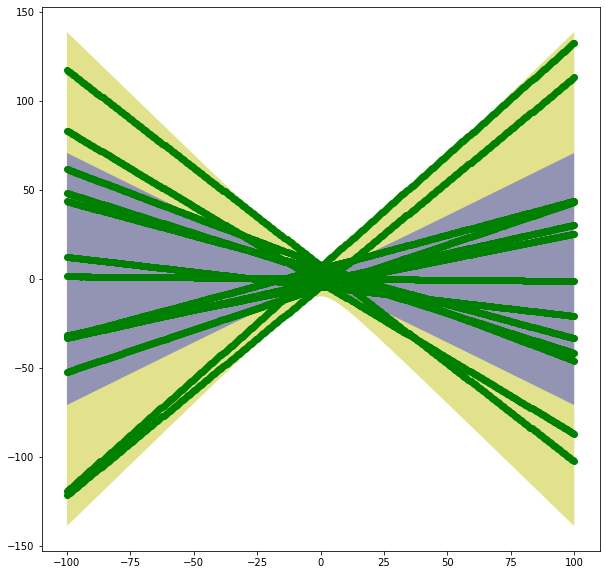

In [169]:
n_tp = 500 # puntos de entrenamiento

x_bot_b = -100.
x_top_b = 100.

x = np.linspace(x_bot_b,x_top_b,n_tp)
y = np.fromiter([np.sin(x)+np.cos(x)+sigma_signal*random.random() for x in x],float)

proyeccionlinear = espacioPropio()
mCov,phi_x,mean = proyeccionlinear.linear(x,sigma_b,sigma_m)
#mCovP = proyeccionlinear.covarianzaProceso(phi_x,mCov)

gp_cov_diag = gaussProcess(mCov,np.zeros(n_tp),phi_x,y)
gp_cov_diag.sigmaCalc(phi_x)
sigmaVal = gp_cov_diag.sigma
visualizacion = datosVisualizacion()

visualizacion.add_sigma(x,sigmaVal)
visualizacion.add_mean(x,np.zeros(n_tp))

[visualizacion.add_data(x,gp_cov_diag.multivariateGauss(n_tp)[0],inset) for inset in range(13) ]

[visualizacion.add_data_plot(inset) for inset in range(13) ]

visualizacion.mostrarPlot()


Este google colab sera un espacio donde practicar conceptos básicos sobre procesos gausianos, en general desarrollar clases para reproducir los conceptos básicos de estos y practicar alguna regresión "de juguete". Muestrea funciones del espacio F:R¹



In [168]:
class espacioPropio():
  '''
  Esta clase define el espacio propio donde proyectamos y la matriz de covarianza resultante
  '''

  def linear(self,x, sigma_b,sigma_m):
    '''
    Se interpretan sigma_b y sigma_m como varianzas de distribuciones a priori gaussianas
    para la ordenada en origen y para la pendiente de nuestro modelo linear.
    x es el input
    '''
    return np.array([[sigma_b,0],[0,sigma_m]]), np.array([np.array([1,xe]) for xe in x]),np.zeros(x.size)

  def covarianzaProceso(self,phi_x,covM):
    '''
    Devuelve la matriz de covarianza final para representar el proceso gausiano unidimensional.
    '''
    return np.matmul(np.matmul(phi_x,covM),phi_x.T)



class gaussProcess():
  def __init__(self,Eps,Mean, Input, Training):
    '''
    Los objetos de esta clase modelan procesos gaussianos caracterizados por su promedio y covarianza
    Eps es la matriz de covarianzas de los pesos del proceso gausiano
    '''
    self.input = Input # Dominio de la regresion
    self.training = Training # Objetivos de la regresióón en el modelo
    self.eps = Eps
    self.mean = Mean
    self.cholDescomp()

  def cholDescomp(self):
    '''
    Cholesky decomposition
    '''
    K = np.matmul(np.matmul(self.input,self.eps),self.input.T)
    try:
      self.L = scipy.linalg.cholesky(K, lower=True)
    except:
      self.L = scipy.linalg.cholesky(K + np.diag(0.0001*np.ones(int(np.sqrt(K.size)))), lower=True)

  def multivariateGauss(self,n):
    '''
    Muestrea colecciones de numeros aleatorios siguiendo una distribucion 
    '''
    
    # n es la cantidad de numeros gaussianos a generar
    gaussNumbers = np.fromiter([ random.gauss(0,1) for x in range(n) ],float)
    print(self.L)
    return [self.mean + np.matmul(self.L,gaussNumbers.T)]

  def sigmaCalc(self,dominio):
    '''
    Desviacion estándar punto a punto del proceso gausiano dado por la matriz de covarianza 
    Es la raiz cuadrado de los elementos de la diagonal de la matriz de covarianzas del proceso generado
    '''
    K = np.matmul(np.matmul(dominio,self.eps),dominio.T)
    self.sigma = np.sqrt(np.diag(K))

class datosVisualizacion():
  '''
  Esta clase contiene los datos de entrenamiento y realizaciones de los procesos gaussianos para la visualización de los mismos
  '''
  def __init__(self):
    self.x = []
    self.y = []
    self.sigma = []
    self.realizacion_dict = {}
    self.inicializacionPlot()

  def add_mean(self,X,Mean):
    '''
    Almacena la desviación estándar de un proceso gausiano dado
    '''
    self.x_mean = X
    self.mean = Mean


  def add_sigma(self,X,Sigma):
    '''
    Almacena la desviación estándar de un proceso gausiano dado
    '''
    self.x_sigma = X
    self.sigma = Sigma

  def add_data(self,X,Y,label):
    self.x.append(X)
    self.y.append(Y)
    self.realizacion_dict[label] = len(self.x)-1

  def inicializacionPlot(self):
    '''
    Inicializa el objeto matplotlib
    '''
    self.fig,self.ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

  def add_data_plot(self,label):
    try:
      self.ax.plot(self.x[self.realizacion_dict[label]],self.y[self.realizacion_dict[label]],'go')
    except:
      print('No existe datos referentes a etiqueta :',label)

  def contorno_sigma(self):
    '''
    Muestra en pantalla contorno de 1 y 2 veces los valores de sigma del proceso gausiano
    '''
    self.ax.fill(np.concatenate((self.x_sigma,self.x_sigma[::-1])),
             np.concatenate((self.mean - 1.9600 * self.sigma,
                             (self.mean + 1.9600 * self.sigma)[::-1])),
             alpha=.45, fc='y', ec='None', label='95% confidence interval')
    self.ax.fill(np.concatenate((self.x_sigma,self.x_sigma[::-1])),
             np.concatenate((self.mean - 1.000 * self.sigma,
                             (self.mean + 1.000 * self.sigma)[::-1])),
             alpha=.35, fc='b', ec='None', label='68% confidence interval')


  def mostrarPlot(self):
    '''
    Muestra plot
    '''
    self.contorno_sigma()
    self.fig.show()



In [ ]:
K = np.array([[2,0,0],[0,5,0],[0,0,6]])
m = np.array([1,2,3])

A = np.array([np.array([1,xe]) for xe in x])

print(A[1])

B = np.array([[1,1],[1,1]])

print(np.matmul(A,B))

#np.fromiter([np.array([1,xe]) for xe in x],float)

#np.array([[0.3,0],[0,0.8]])

[1.         0.20408163]
[[ 1.          1.        ]
 [ 1.20408163  1.20408163]
 [ 1.40816327  1.40816327]
 [ 1.6122449   1.6122449 ]
 [ 1.81632653  1.81632653]
 [ 2.02040816  2.02040816]
 [ 2.2244898   2.2244898 ]
 [ 2.42857143  2.42857143]
 [ 2.63265306  2.63265306]
 [ 2.83673469  2.83673469]
 [ 3.04081633  3.04081633]
 [ 3.24489796  3.24489796]
 [ 3.44897959  3.44897959]
 [ 3.65306122  3.65306122]
 [ 3.85714286  3.85714286]
 [ 4.06122449  4.06122449]
 [ 4.26530612  4.26530612]
 [ 4.46938776  4.46938776]
 [ 4.67346939  4.67346939]
 [ 4.87755102  4.87755102]
 [ 5.08163265  5.08163265]
 [ 5.28571429  5.28571429]
 [ 5.48979592  5.48979592]
 [ 5.69387755  5.69387755]
 [ 5.89795918  5.89795918]
 [ 6.10204082  6.10204082]
 [ 6.30612245  6.30612245]
 [ 6.51020408  6.51020408]
 [ 6.71428571  6.71428571]
 [ 6.91836735  6.91836735]
 [ 7.12244898  7.12244898]
 [ 7.32653061  7.32653061]
 [ 7.53061224  7.53061224]
 [ 7.73469388  7.73469388]
 [ 7.93877551  7.93877551]
 [ 8.14285714  8.14285714]
 [ 8